# Single-Particle Gyromotion in a Constant Magnetic Field

## Introduction
In this tutorial, we simulate the trajectory of a **single charged particle** in a **constant magnetic field** using **PlasmaTorch**. Specifically, we demonstrate how the particle executes **circular motion** (gyromotion) due to the Lorentz force.

### Physical Background
When a charged particle (charge $q$, mass $m$) moves in a constant magnetic field $\mathbf{B} = B\hat{z}$ with initial velocity perpendicular to $\mathbf{B}$, it experiences a Lorentz force:
$$ 
  \mathbf{F} = q \mathbf{v} \times \mathbf{B}. 
$$
For $v_{\parallel} = 0$ (no velocity component along the magnetic field), the particle undergoes uniform circular motion in the plane perpendicular to $\mathbf{B}$. The cyclotron frequency (or gyrofrequency) is given by:
$$
  \omega_c = \frac{q B}{m},
$$
and the **gyro-radius** $r$ is determined by the perpendicular velocity $v_\perp$:
$$
  r = \frac{v_\perp}{\omega_c}.
$$
In this tutorial, we set $q = 1$, $m = 1$, and $B = 0.0001$ (in convenient units). We initially give the particle a velocity in the $x$-direction of $1.0$ (arbitrary units) and watch it rotate about the magnetic field axis.

## Cell 1: Imports and Basic Setup
We:
- Reload modules with `%autoreload`.
- Import Python libraries and **PlasmaTorch** modules.
- Append local directories for **PlasmaTorch**.
- Set the device (`cuda` or `cpu`).
- Fix the random seed for reproducibility.

In [4]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.autograd.profiler as profiler
from scipy.constants import *
import sys
sys.path.append("../")
sys.path.append("../plasmatorch")

from plasmatorch.simulator import *
from plasmatorch.utils import *
from plasmatorch.deposition import *
from plasmatorch.fields import *
from plasmatorch.helper import *

device = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(2304)

## Cell 2: Defining the Simulation and a Single Particle
- We choose a 2D domain of size $L_x = L_y = 2.0$ with a 32 × 32 grid.
- We set the time step to $\mathrm{d}t = 10^{-4}$ and run until $t = 0.1$.
- Use **PlasmaTorch** with **periodic** boundaries.
- Create a single particle named `single_particle_B` at the center of the domain $(1.0, 1.0)$, with initial velocity $(v_x, v_y) = (1.0, 0)$. Mass $m=1$ and charge $q=1$.
- Define a uniform magnetic field in the $z$-direction, $B_z = 0.0001$.
- Remove any electric field contribution by setting `sim.fields[:, :, 0, :] = 0.0`.
- Finally, run the simulation (`sim.simulate()`) and print out the final position and velocity of the particle.

In [17]:
Lx, Ly = 2.0, 2.0
Nx, Ny = 32, 32
dt = 1e-4
simulation_time = 0.1
backend = "cpu"
simulation_name = "Test"

sim = PlasmaTorch(
    simulation_name=simulation_name,
    Lx=Lx,
    Ly=Ly,
    Nx=Nx,
    Ny=Ny,
    simulation_time=simulation_time,
    dt=dt,
    boundaries_type="periodic",
    save_frequency=10,
    backend= backend,
)

sim.poisson_method = "gauss_seidel"

# Create a particle with q=1, m=1, initial velocity in x
sim.create_new_specie(
    name="single_particle_B",
    num_particles=1,
    temperature=0.0,
    distribution="zero",
    disposition="specific",
    position=[1.0, 1.0],
    mass=1.0,
    charge=1.0
)

# Set initial velocity
sim.particles_velocity[0, 0] = 1.0  # vx
sim.particles_velocity[0, 1] = 0.0  # vy
sim.particles_velocity[0, 2] = 0.0

# Define uniform magnetic field Bz
Bz = 0.0001
sim.define_constant_magnetic_field(
    x_min=0, x_max=Lx,
    y_min=0, y_max=Ly,
    bz=Bz
)

# Remove any electric field contribution
sim.fields[:, :, 0, :] = 0.0

sim.simulate()

# Print final particle position and velocity
final_position = sim.particles_position[0].cpu().numpy()
print("Posizione finale:", final_position)
final_velocity = sim.particles_velocity[0].cpu().numpy()
print("Velocità finale:", final_velocity)


100%|██████████| 1000/1000 [07:05<00:00,  2.35 step/s]

Posizione finale: [ 1.9472656   0.24511719 -0.92219055]
Velocità finale: [-1.0307068e+08 -6.6246800e+07 -9.5432541e+01]


## Cell 3: Additional Check on Final Velocity
If needed, we can re-check or re-print the velocity after the simulation.

In [18]:
final_velocity = sim.particles_velocity[0].cpu().numpy()
print("Velocità finale:", final_velocity)

Velocità finale: [-1.0307068e+08 -6.6246800e+07 -9.5432541e+01]


## Cell 4: Reloading the Simulation
We can reload the simulation results from disk for further analysis or plotting. This also allows us to visualize or compute additional diagnostics without re-running the simulation.

In [6]:
simulation = load_simulation(simulation_name, device= "cpu")

[INFO] Loaded datasets from Test: ['charge_register', 'fields_chronology', 'fixed_potential_mask', 'fixed_potential_value', 'grid_chronology', 'kinetic_energy_chronology', 'mass_register', 'mechanic_energy_chronology', 'particles_active_chronology', 'particles_position_chronology', 'particles_specie_chronology', 'particles_velocity_chronology', 'potential_energy_chronology', 'solid_mask', 'solid_type']


## Cell 5: Visualizing the Trajectory
Using the `%matplotlib widget` backend, we can leverage `dynamic_slider` to visualize the particle's trajectory over time. This interactive slider will show how the single particle moves step-by-step in the presence of a constant magnetic field.

We expect to see **circular motion** (gyromotion) around the $z$-axis.

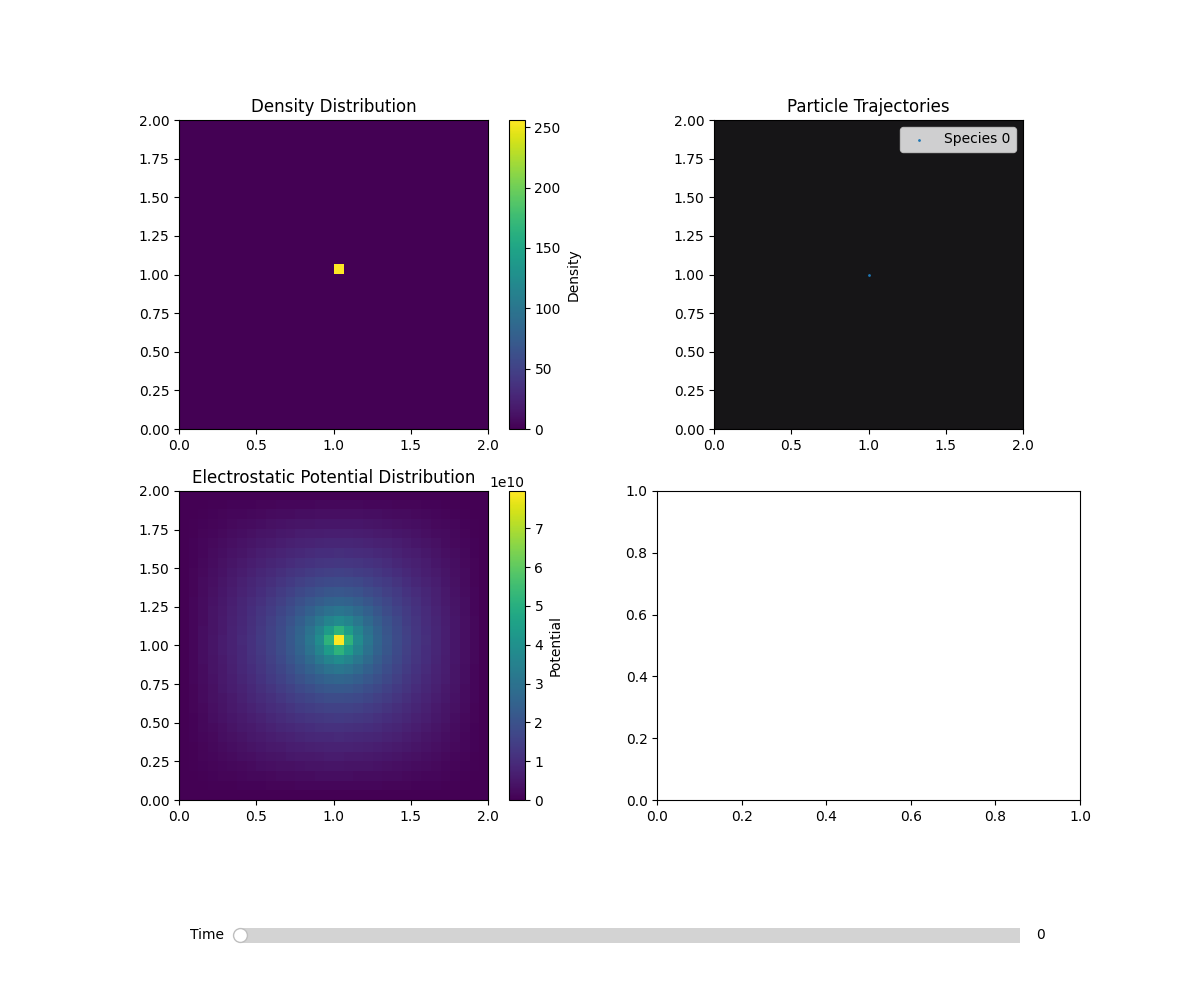

In [8]:
%matplotlib widget

dynamic_slider(simulation, Lx, Ly)

## Conclusions
This tutorial demonstrated how to simulate the **gyromotion** of a single charged particle in a constant magnetic field using **PlasmaTorch**. With $q = 1$, $m = 1$, and $B_z = 0.0001$, the particle describes (approximately) circular orbits about the $z$-axis, with the cyclotron frequency given by
$$ 
\omega_c = \frac{q B}{m}. 
$$
By comparing the final position and velocity with the initial conditions, and observing the circular trajectory, we confirm that the simulation captures the basic Lorentz force dynamics. This setup can be extended to multiple particles, more complex geometries, or non-uniform magnetic fields to explore richer plasma physics phenomena.